# Binary Classification with a Bank Churn Dataset

## Libraries 불러오기

In [2]:
pip install optuna


   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
   ------------------ --------------------- 194.6/413.4 kB 5.8 MB/s eta 0:00:01
   ----------------------------------- ---- 368.6/413.4 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 413.4/413.4 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.4 kB ? eta -:--:--
   --------------------- ------------------ 122.9/233.4 kB 3.6 MB/s eta 0:00:01
   -------------------------------------- - 225.3/233.4 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 233.4/233.4 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ---------------------------------------- 78.6/78.6 kB 2.1 MB/s eta 0:00:00


In [199]:
import numpy as np # linear algebra
import pandas as pd # data processing
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

# scikit-learn utilities
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

# Models
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# optuna for hyperparams tuning
import optuna
from optuna.samplers import TPESampler

# Ignore warnings 
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

rc('font', family='Malgun Gothic')
sns.set_style('whitegrid')

from imblearn.over_sampling import SMOTE



## 데이터 불러오기

In [146]:
train_path     = "MachineLearningPJ/train.csv"
test_path      = "MachineLearningPJ/test.csv"
original_path  = "MachineLearningPJ/Churn_Modelling.csv"

def import_data(train_path, test_path, original_path):     
    train      =  pd.read_csv(train_path)
    test       =  pd.read_csv(test_path)
    original   =  pd.read_csv(original_path)
    
    return train, test, original

train, test, original = import_data(train_path, test_path, original_path)

## EDA

In [70]:
train.head(3)

id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   

   Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0      0.0              2        1.0             0.0        181449.97       0  
1      0.0              2        1.0             1.0         49503.50       0  
2      0.0              2        1.0             0.0        184866.69       0

In [71]:
train.shape

(165034, 14)

In [72]:
original.head(3)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender   Age  \
0          1    15634602  Hargrave          619    France  Female  42.0   
1          2    15647311      Hill          608     Spain  Female  41.0   
2          3    15619304      Onio          502    France  Female  42.0   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1        1.0             1.0   
1       1   83807.86              1        0.0             1.0   
2       8  159660.80              3        1.0             0.0   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1

In [73]:
test.head(3)

id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0  165034    15773898  Lucchese          586    France  Female  23.0       2   
1  165035    15782418      Nott          683    France  Female  46.0       2   
2  165036    15807120        K?          656    France  Female  34.0       7   

   Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0      0.0              2        0.0             1.0        160976.75  
1      0.0              1        1.0             0.0         72549.27  
2      0.0              2        1.0             0.0        138882.09

### 1. Univariate Analysis (단변량 분석)

In [74]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [75]:
train.describe().T
#누락된 값이 없음

count          mean           std          min  \
id               165034.0  8.251650e+04  47641.356500         0.00   
CustomerId       165034.0  1.569201e+07  71397.816791  15565701.00   
CreditScore      165034.0  6.564544e+02     80.103340       350.00   
Age              165034.0  3.812589e+01      8.867205        18.00   
Tenure           165034.0  5.020353e+00      2.806159         0.00   
Balance          165034.0  5.547809e+04  62817.663278         0.00   
NumOfProducts    165034.0  1.554455e+00      0.547154         1.00   
HasCrCard        165034.0  7.539537e-01      0.430707         0.00   
IsActiveMember   165034.0  4.977702e-01      0.499997         0.00   
EstimatedSalary  165034.0  1.125748e+05  50292.865585        11.58   
Exited           165034.0  2.115988e-01      0.408443         0.00   

                         25%         50%           75%          max  
id                  41258.25     82516.5  1.237748e+05    165033.00  
CustomerId       15633141.00  15690169.0  1.575682e+07  15815690.00  
CreditScore           597.00       659.0  7.100000e+02       850.00  
Age                    32.00        37.0  4.200000e+01        92.00  
Tenure                  3.00         5.0  7.000000e+00        10.00  
Balance                 0.00         0.0  1.199395e+05    250898.09  
NumOfProducts           1.00         2.0  2.000000e+00         4.00  
HasCrCard               1.00         1.0  1.000000e+00         1.00  
IsActiveMember          0.00         0.0  1.000000e+00         1.00  
EstimatedSalary     74637.57    117948.0  1.551525e+05    199992.48  
Exited                  0.00         0.0  0.000000e+00         1.00

In [121]:
# 숫자 열 및 범주형 열 목록

numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
binary_cols  = ['HasCrCard', 'IsActiveMember']
categ_cols   = train.select_dtypes(include=['object']).columns.tolist()
target       = 'Exited'

print(f"Numerical columns list   ---> {numeric_cols}")
print(f"Binary columns list      ---> {binary_cols}")
print(f"Categorical columns list ---> {categ_cols}")

Numerical columns list   ---> ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Binary columns list      ---> ['HasCrCard', 'IsActiveMember']
Categorical columns list ---> ['Surname', 'Geography', 'Gender']


In [122]:
# 단변량 통계를 계산하는 기능
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df[numeric_cols + categ_cols]:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]

    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [123]:
# train 데이터셋의 단변량 통계를 확인하는 함수를 호출
univariate_stats(train)

Count  Missing  Unique    Dtype  IsNumeric      Mode  \
EstimatedSalary  165034        0   55298  float64       True  88890.05   
Balance          165034        0   30075  float64       True       0.0   
CreditScore      165034        0     457    int64       True     850.0   
Age              165034        0      71  float64       True      37.0   
Tenure           165034        0      11    int64       True       2.0   
NumOfProducts    165034        0       4    int64       True       2.0   
Surname          165034        0    2797   object      False      Hsia   
Geography        165034        0       3   object      False    France   
Gender           165034        0       2   object      False      Male   

                          Mean    Min       25%    Median          75%  \
EstimatedSalary  112574.822734  11.58  74637.57  117948.0  155152.4675   
Balance           55478.086689    0.0       0.0       0.0  119939.5175   
CreditScore         656.454373  350.0     597.0     659.0        710.0   
Age                  38.125888   18.0      32.0      37.0         42.0   
Tenure                5.020353    0.0       3.0       5.0          7.0   
NumOfProducts         1.554455    1.0       1.0       2.0          2.0   
Surname                      -      -         -         -            -   
Geography                    -      -         -         -            -   
Gender                       -      -         -         -            -   

                       Max           Std      Skew      Kurt  
EstimatedSalary  199992.48  50292.865585 -0.309022 -0.838845  
Balance          250898.09  62817.663278   0.38202 -1.600852  
CreditScore          850.0      80.10334 -0.059291 -0.067452  
Age                   92.0      8.867205  0.968063  1.532406  
Tenure                10.0      2.806159   0.00649 -1.157921  
NumOfProducts          4.0      0.547154  0.368278 -0.278059  
Surname                  -             -         -         -  
Geography                -             -         -         -  
Gender                   -             -         -         -

In [124]:
# test 데이터셋의 단변량 통계를 확인하는 함수를 호출
univariate_stats(test)

Count  Missing  Unique    Dtype  IsNumeric      Mode  \
EstimatedSalary  110023        0   41670  float64       True  88890.05   
Balance          110023        0   22513  float64       True       0.0   
CreditScore      110023        0     454    int64       True     850.0   
Age              110023        0      74  float64       True      38.0   
Tenure           110023        0      11    int64       True       2.0   
NumOfProducts    110023        0       4    int64       True       2.0   
Surname          110023        0    2708   object      False      Hsia   
Geography        110023        0       3   object      False    France   
Gender           110023        0       2   object      False      Male   

                          Mean    Min        25%     Median         75%  \
EstimatedSalary  112315.147765  11.58  74440.325  117832.23   154631.35   
Balance           55333.611354    0.0        0.0        0.0  120145.605   
CreditScore         656.530789  350.0      597.0      660.0       710.0   
Age                  38.122205   18.0       32.0       37.0        42.0   
Tenure                4.996637    0.0        3.0        5.0         7.0   
NumOfProducts         1.553321    1.0        1.0        2.0         2.0   
Surname                      -      -          -          -           -   
Geography                    -      -          -          -           -   
Gender                       -      -          -          -           -   

                       Max           Std      Skew      Kurt  
EstimatedSalary  199992.48  50277.048244 -0.305291 -0.841998  
Balance          250898.09  62788.519675  0.385218 -1.602315  
CreditScore          850.0     80.315415 -0.062401 -0.068427  
Age                   92.0       8.86155  0.972404  1.588648  
Tenure                10.0      2.806148  0.021346 -1.152985  
NumOfProducts          4.0      0.544714  0.350358 -0.324378  
Surname                  -             -         -         -  
Geography                -             -         -         -  
Gender                   -             -         -         -

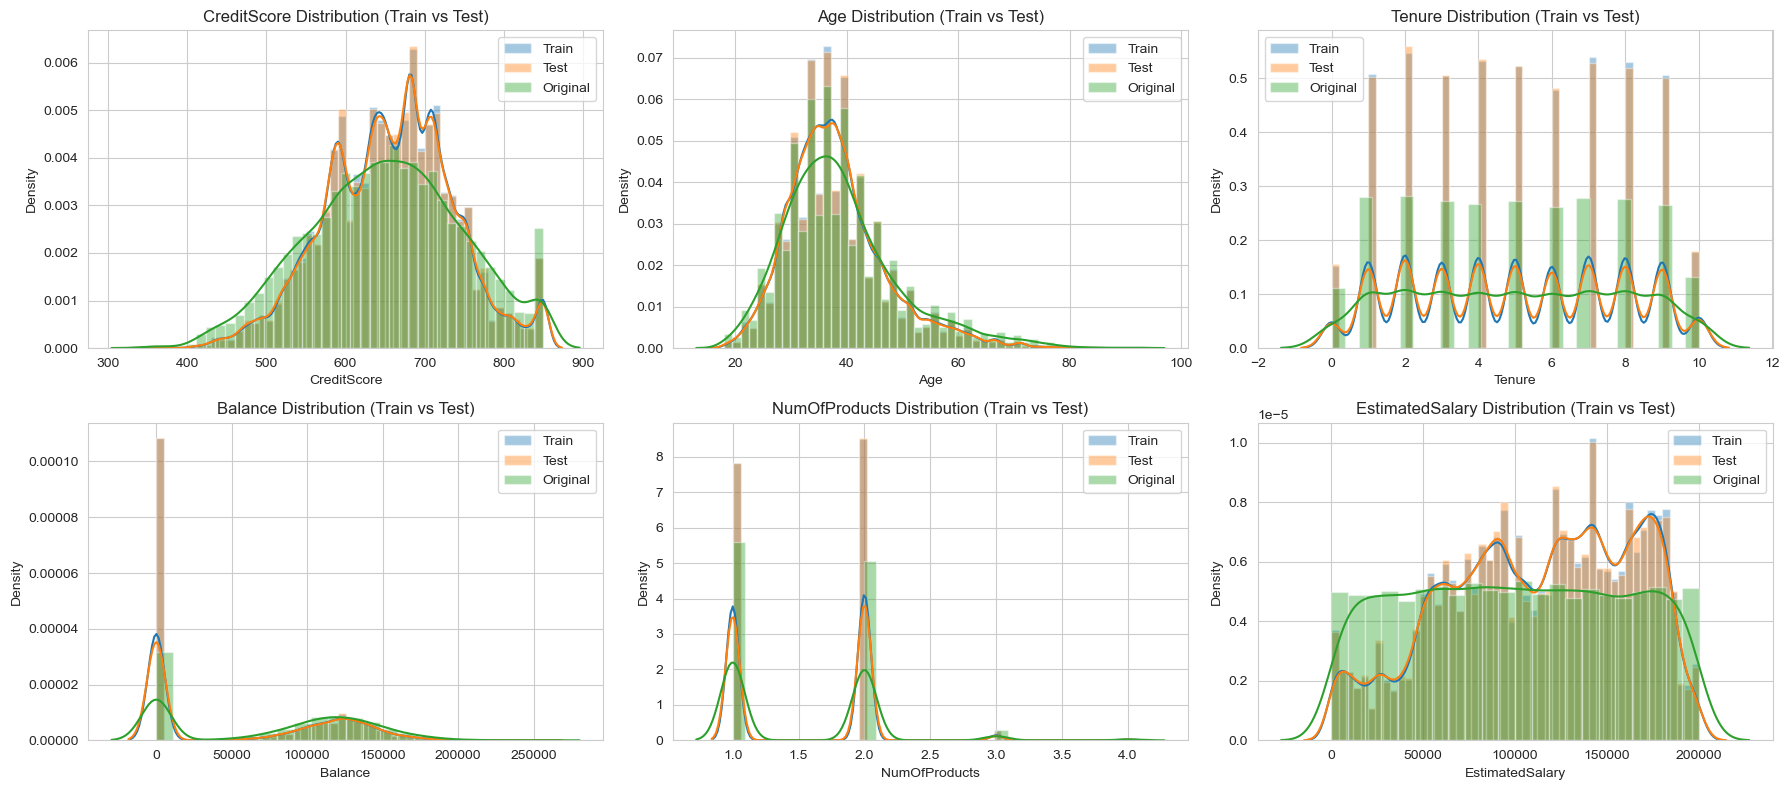

In [80]:
#분포분석(train - test)
def plot_histograms(df_train, df_test, original, target, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train[numeric_cols], test[numeric_cols], original[numeric_cols], target, n_cols=3)

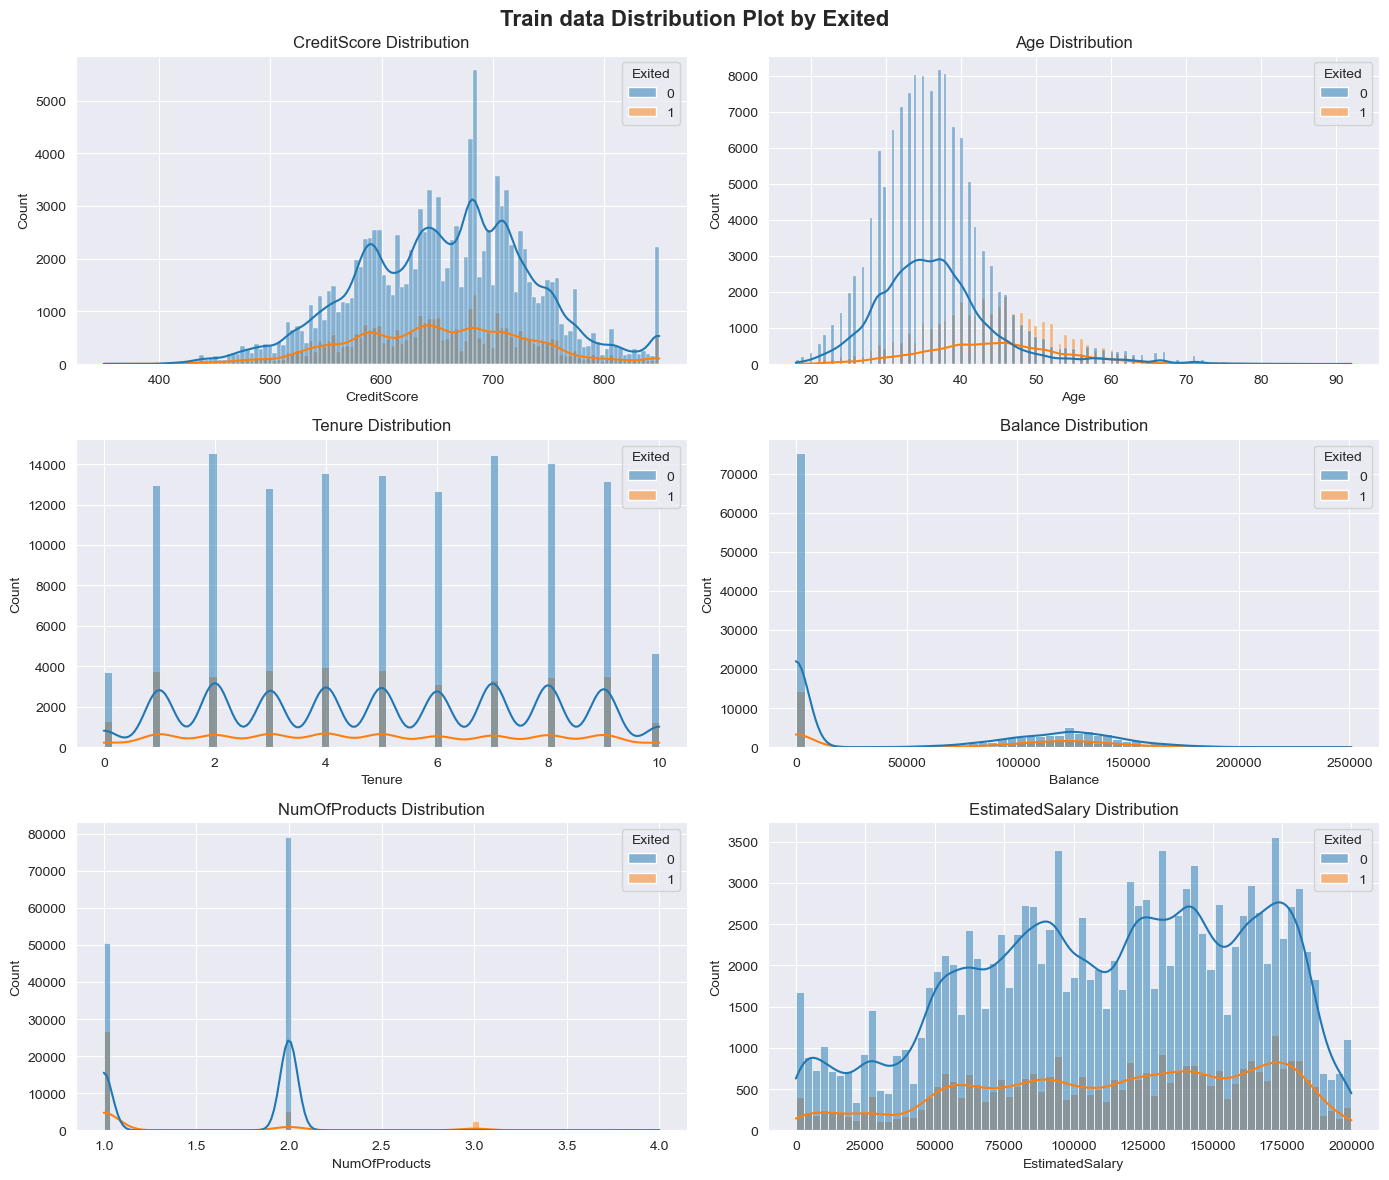

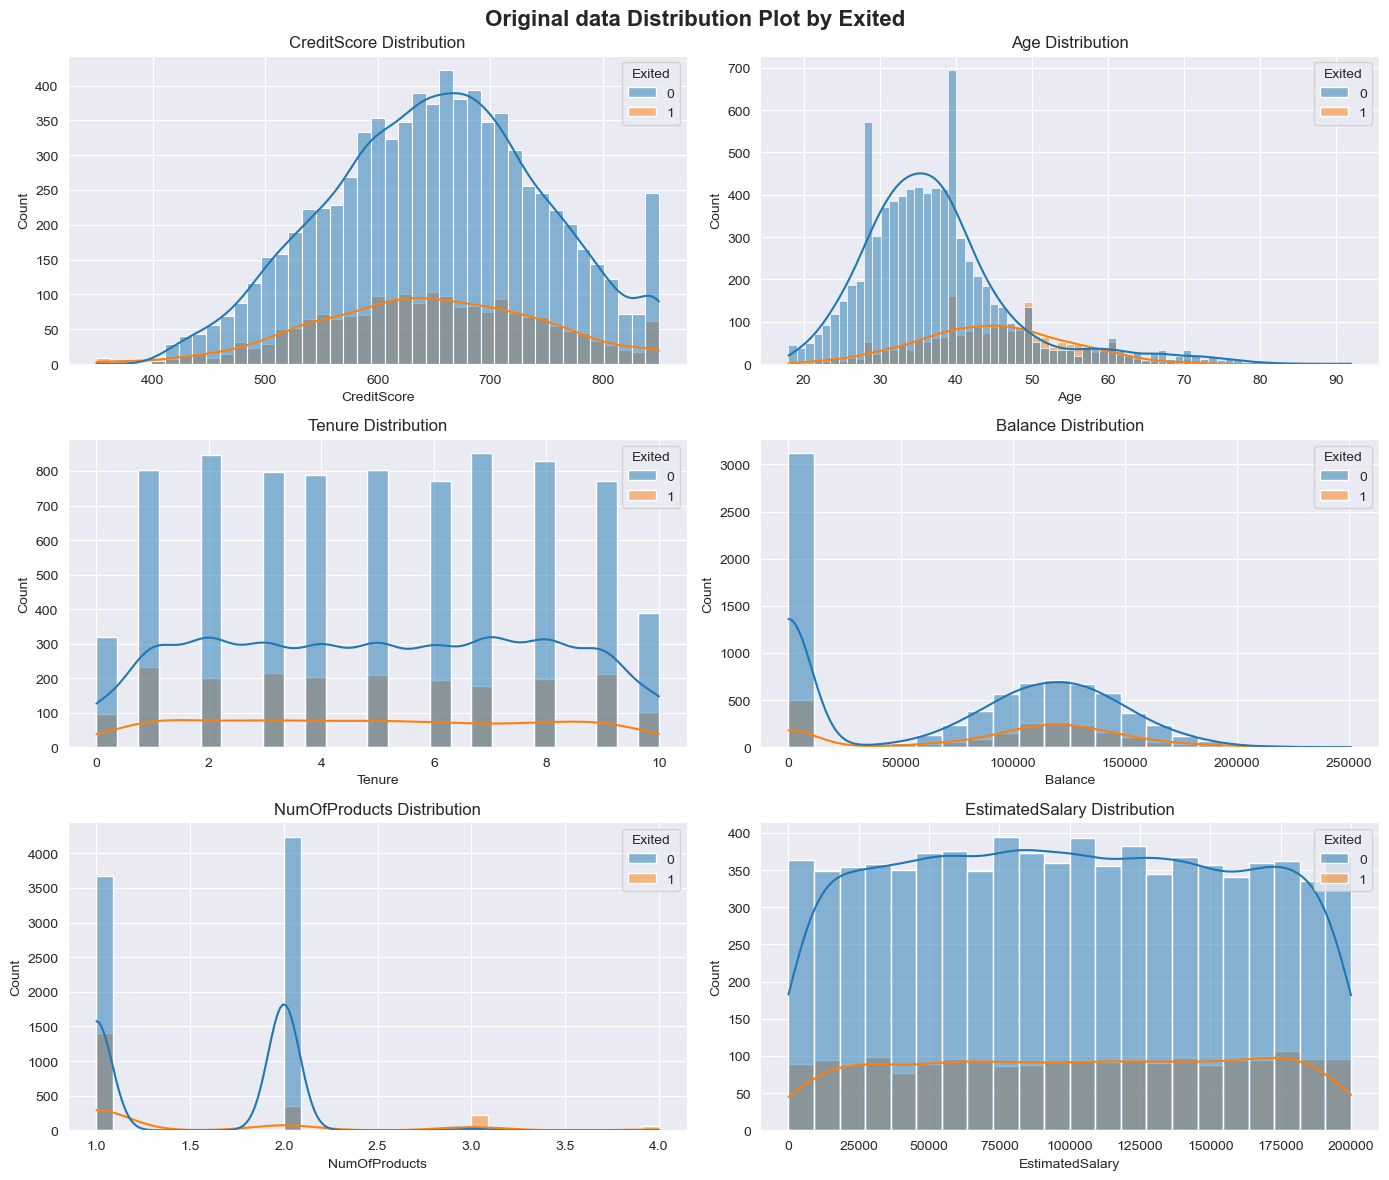

In [81]:
# train data - original data 이탈률 분포
def plot_distribution(df, hue, title='', drop_cols=[]):
    sns.set_style('darkgrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distribution(train[numeric_cols+[target]], hue=target, title='Train data')
#plot_distribution(test[numeric_cols+[target]], hue=target, title='Test data')
plot_distribution(original[numeric_cols+[target]], hue=target, title='Original data')

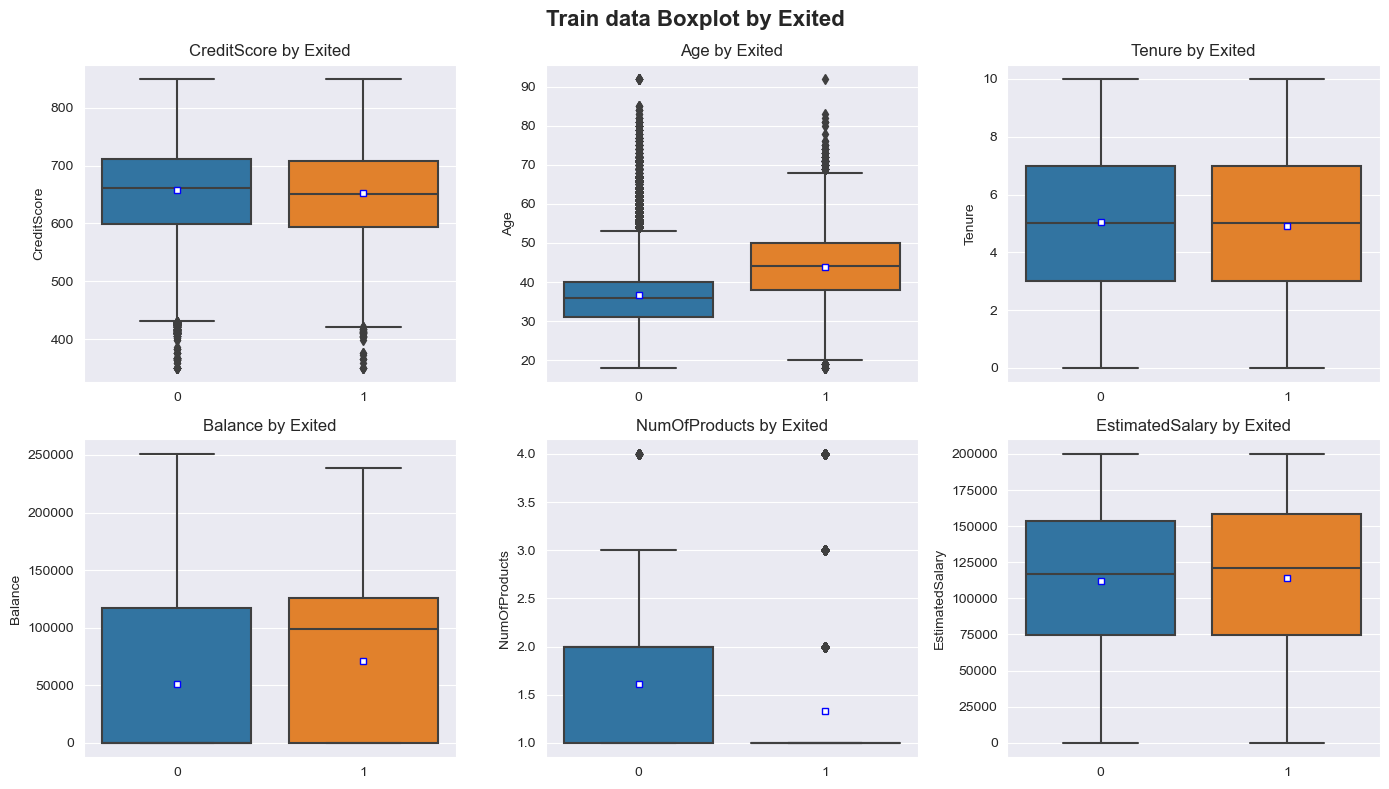

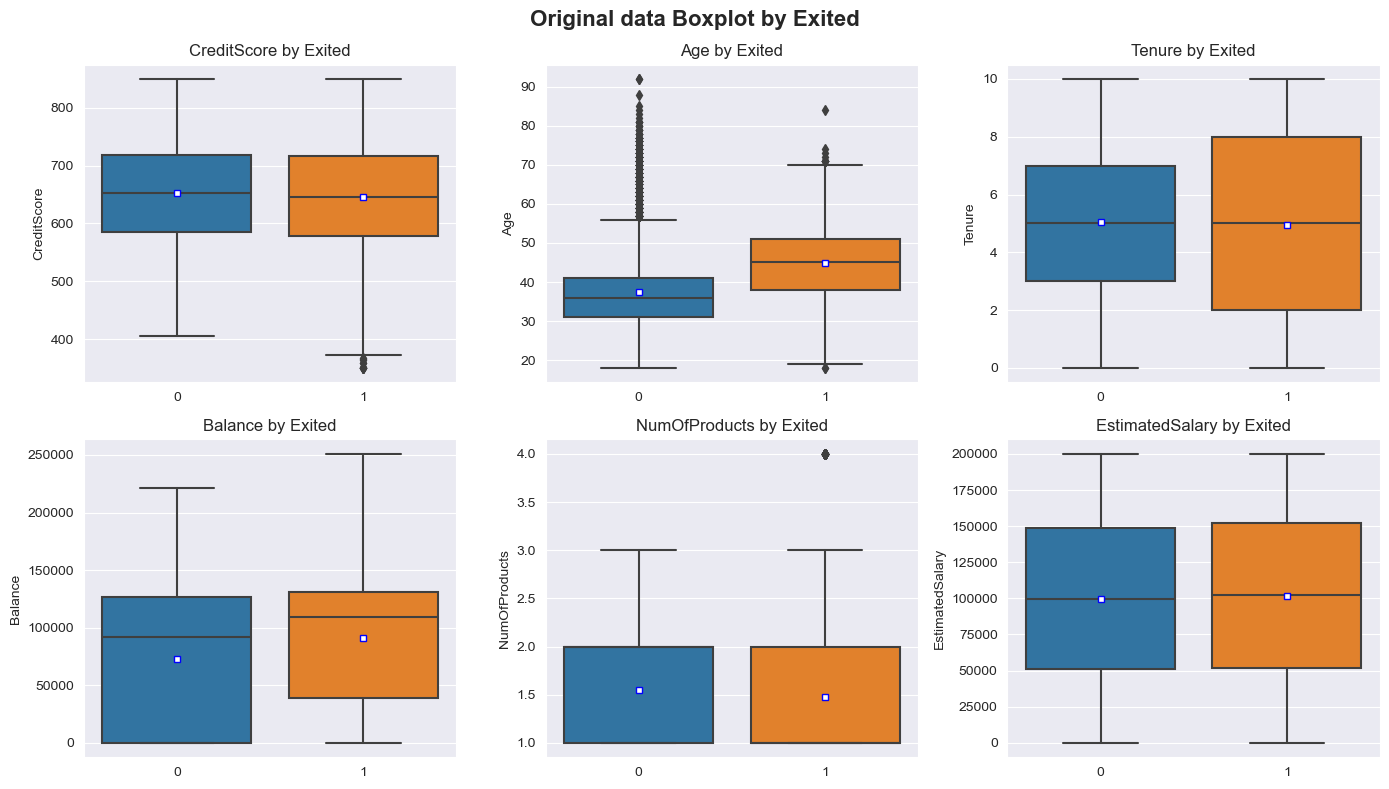

In [82]:
# train data - original data 이탈률 분포(box plot)
def plot_boxplot(df, hue, title='', drop_cols=[], n_cols=3):
    sns.set_style('darkgrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True, 
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_boxplot(train[numeric_cols+[target]], hue=target, n_cols=3, title='Train data')
plot_boxplot(original[numeric_cols+[target]], hue=target, n_cols=3, title='Original data')

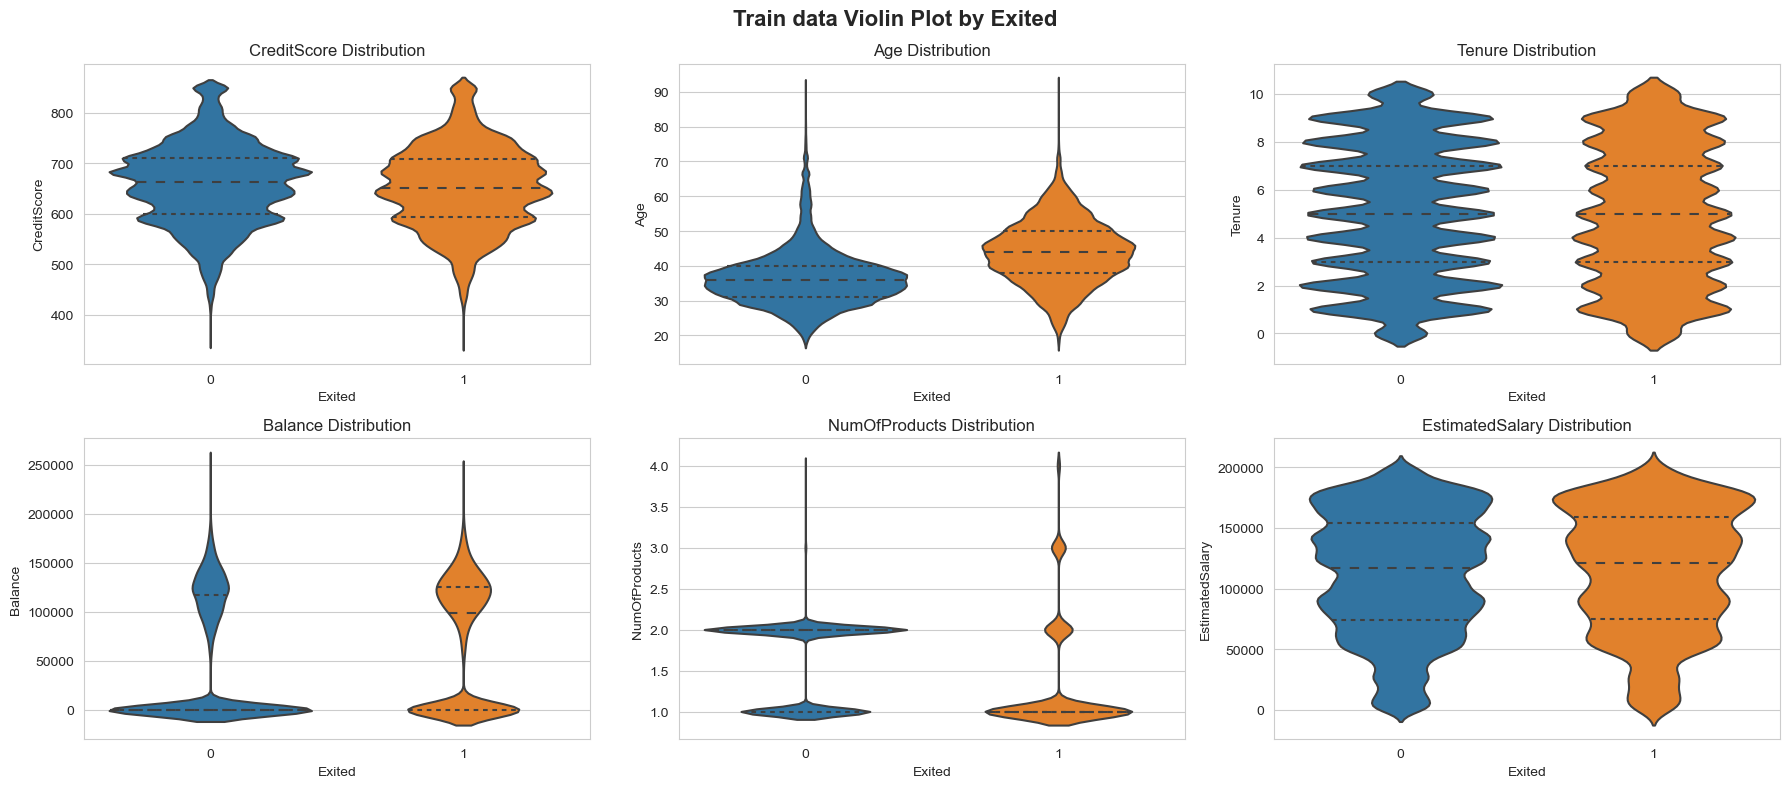

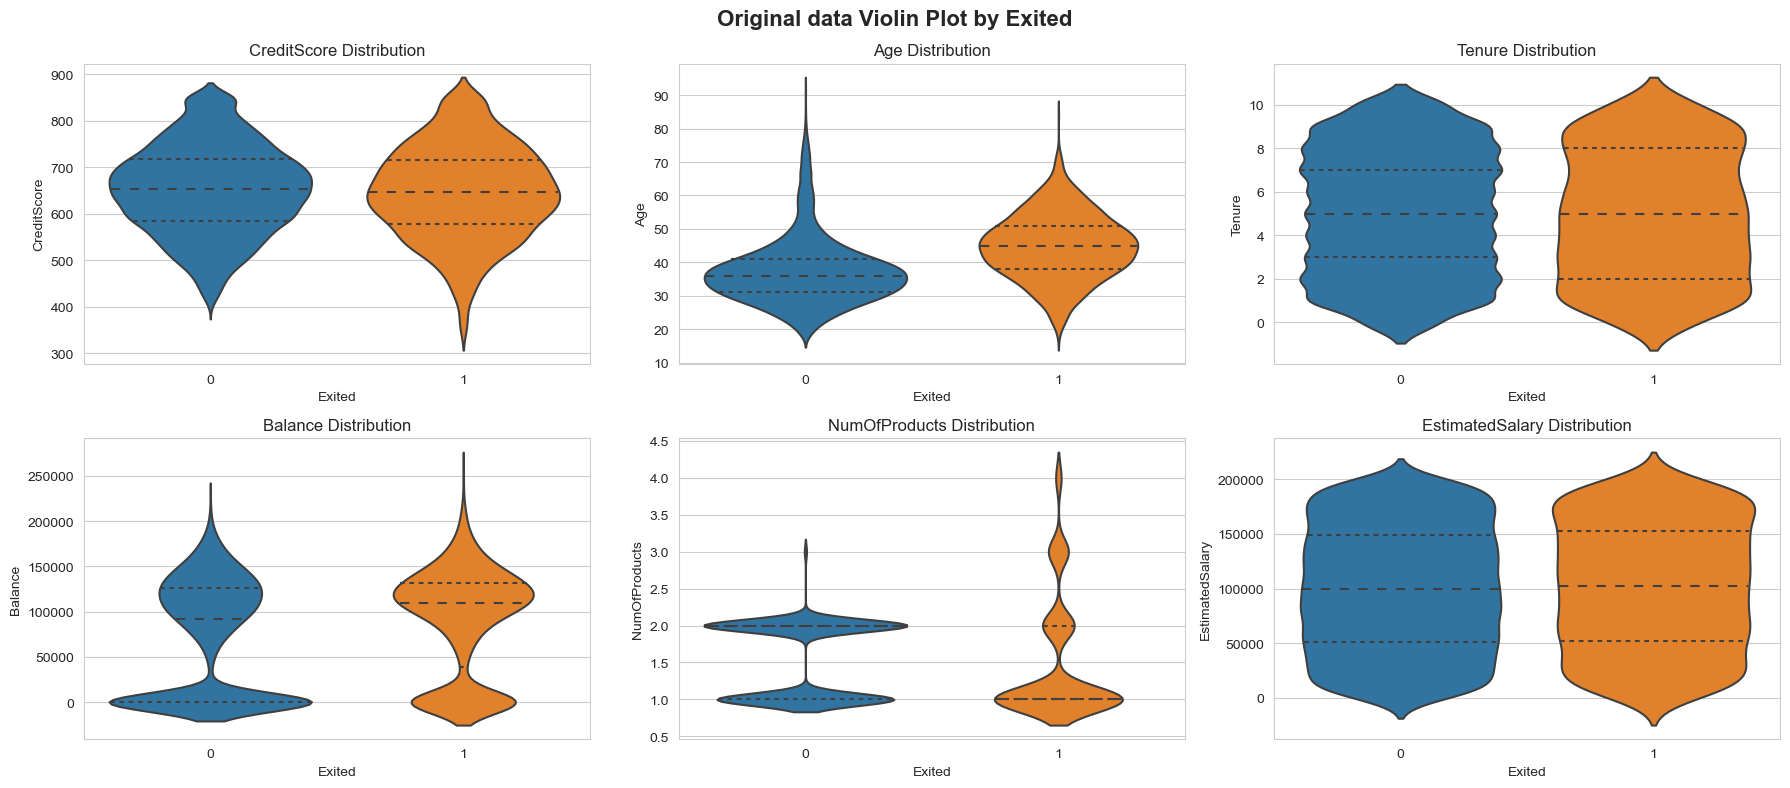

In [83]:
# train data - original data 이탈률 분포(violin plot)
def plot_violinplot(df, hue, drop_cols=[], n_cols=2, title=''):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.violinplot(data=df, x=hue, y=var_name, ax=ax, inner='quartile')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Violin Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_violinplot(train[numeric_cols+[target]], hue=target, n_cols=3, title='Train data')
plot_violinplot(original[numeric_cols+[target]], hue=target, n_cols=3, title='Original data')

In [84]:
#오류 시각화 
def plot_binary_machine_failures(dataframe, column):
    # Plot the machine failures
    plt.figure(figsize=(4, 4))

    # Countplot for Machine failure
    ax = plt.subplot(1, 2, 1)
    ax = sns.countplot(x=column, data=dataframe)
    ax.bar_label(ax.containers[0])
    plt.title(column, fontsize=10)

    # Pie chart for Outcome
    ax = plt.subplot(1, 2, 2)
    outcome_counts = dataframe[column].value_counts()
    ax = outcome_counts.plot.pie(explode=[0.1, 0.1], autopct='%1.2f%%', shadow=True)
    ax.set_title("Pie", fontsize=20, color='Red', font='Lucida Calligraphy')

    # Display the plot
    plt.tight_layout()
    plt.show()

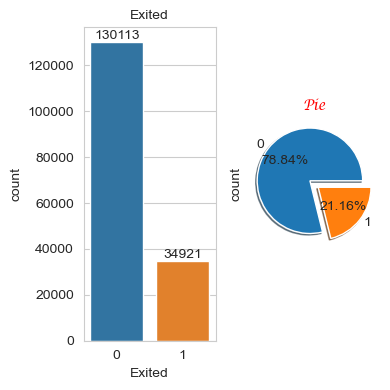

In [85]:
# target balance 시각화 (train data)
plot_binary_machine_failures(train, target)

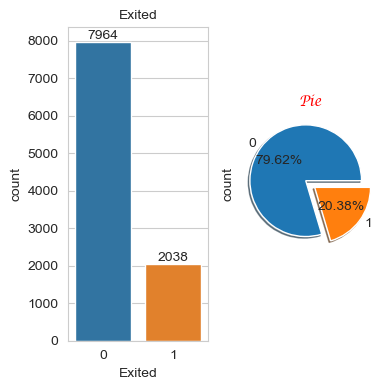

In [86]:
# target balance 시각화 (original data)
plot_binary_machine_failures(original, target)

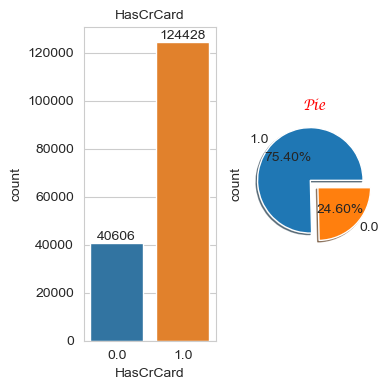

In [87]:
plot_binary_machine_failures(train, binary_cols[0])

#타겟 컬럼과 HasCrCard 컬럼의 밸런스가 맞지 않음

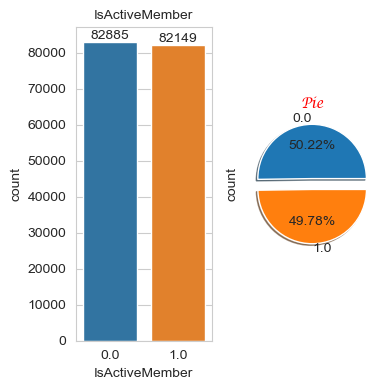

In [88]:
plot_binary_machine_failures(train, binary_cols[1])

# IsActiveMember 열의 균형이 잘 잡혀 있음

## 2. Bivariate Analysis (이변량 분석: 두 변수 상관관계)

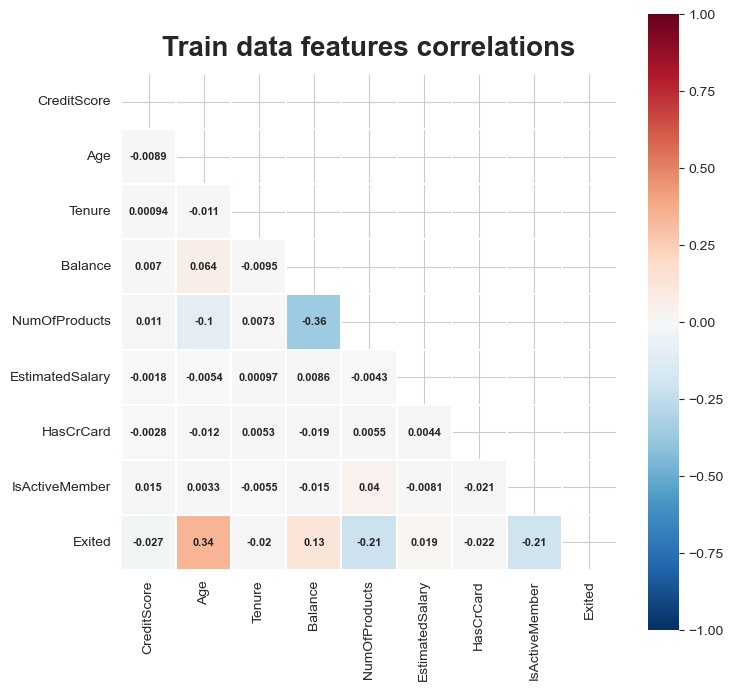

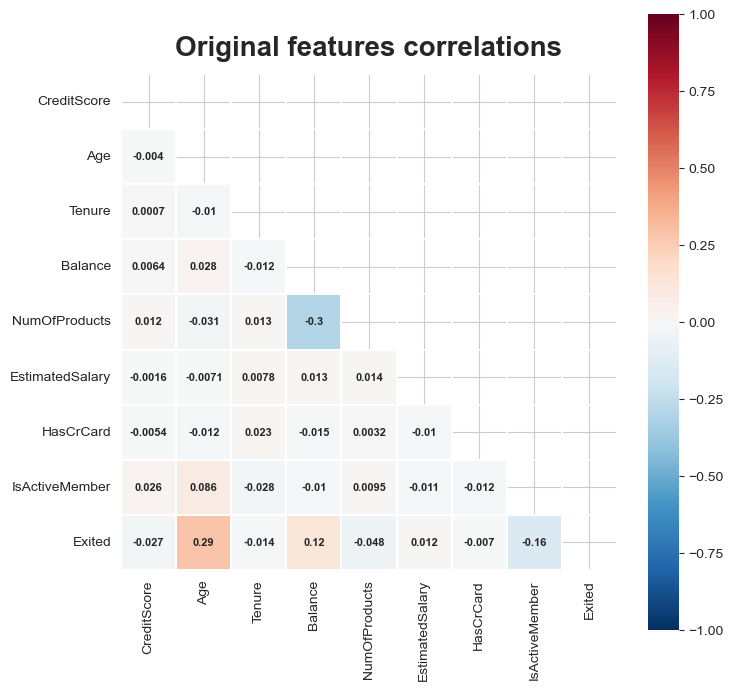

In [89]:
def plot_heatmap(df, title):
    
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(8, 8))

    plt.title(f'{title} features correlations', fontweight='bold', y=1.02, size=20)

    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 8, "weight": "bold"},
                mask=mask)

plot_heatmap(train[numeric_cols+binary_cols+[target]], title='Train data')
plot_heatmap(original[numeric_cols+binary_cols+[target]], title='Original')

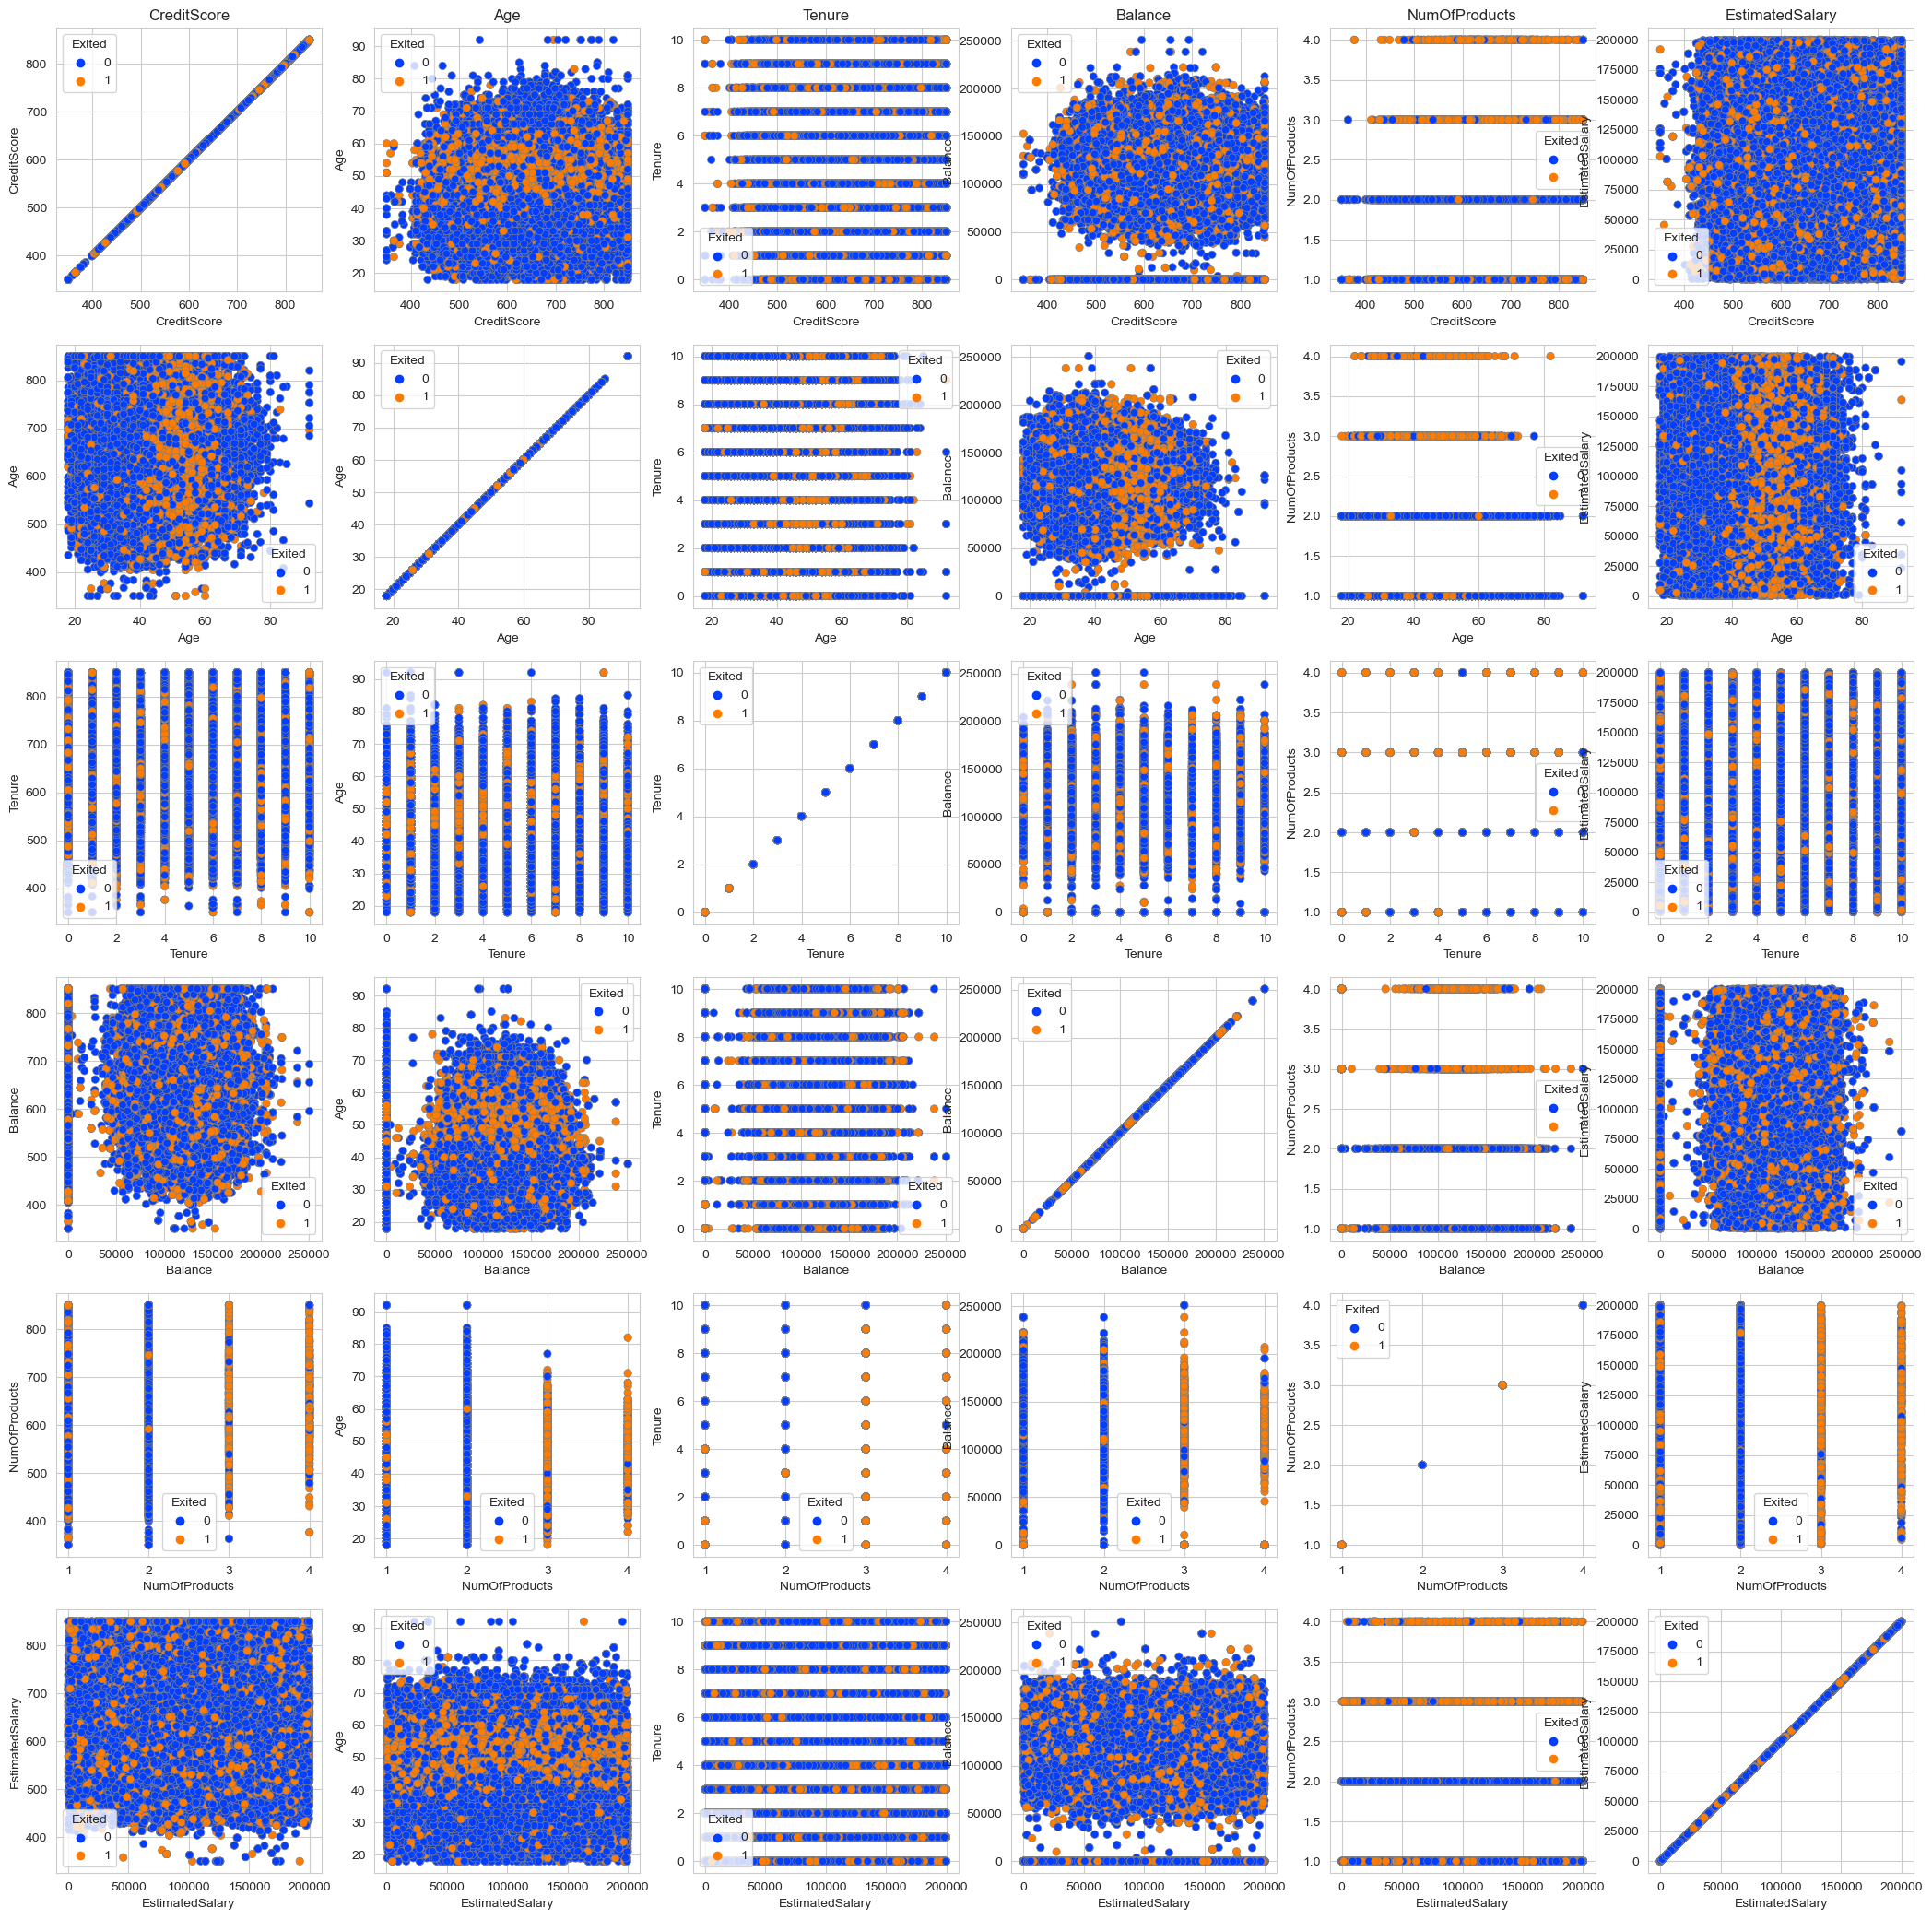

In [22]:
def plot_scatter_matrix(df, target_col, drop_cols=[], size=26):
    # sns.pairplot()
    
    sns.set_style('whitegrid')
    cols = df.columns.drop([target_col] + drop_cols)
    fig, axes = plt.subplots(len(cols), len(cols), figsize=(size, size), sharex=False, sharey=False)

    for i, col in enumerate(cols):
        for j, col_ in enumerate(cols):
            axes[i,j].set_xlabel(f'{col}')
            axes[i,j].set_ylabel(f'{col_}')

            # Plot the scatterplot
            sns.scatterplot(data=df, x=col, y=col_, hue=target_col, ax=axes[i,j],
                             edgecolor='gray', palette='bright')

            axes[i,j].tick_params(axis='both', which='major')

            if i == 0:
                axes[i,j].set_title(f'{col_}')
            if j == 0:
                axes[i,j].set_ylabel(f'{col}')
                
    plt.show()
    
plot_scatter_matrix(train[numeric_cols+[target]], target)

## Feature Engineering 
##### 모델 정확도를 높이기 위해 주어진 데이터를 예측모델의 문제를 잘 표현할 수 있는 feature로 변형시키는 과정

In [24]:
original_true_labels = original[original[target] == 1].drop('RowNumber', axis=1)
print("Original Data Shape: ", original_true_labels.shape)

# concatenate datasets
df_all = pd.concat([train, original_true_labels], ignore_index=True)
df_all = df_all.drop_duplicates()
df_all

Original Data Shape:  (2038, 13)


id  CustomerId         Surname  CreditScore Geography  Gender   Age  \
0       0.0    15674932  Okwudilichukwu          668    France    Male  33.0   
1       1.0    15749177   Okwudiliolisa          627    France    Male  33.0   
2       2.0    15694510           Hsueh          678    France    Male  40.0   
3       3.0    15741417             Kao          581    France    Male  34.0   
4       4.0    15766172       Chiemenam          716     Spain    Male  33.0   
...     ...         ...             ...          ...       ...     ...   ...   
167066  NaN    15672754        Burbidge          498   Germany    Male  42.0   
167067  NaN    15768163         Griffin          655   Germany  Female  46.0   
167068  NaN    15769959     Ajuluchukwu          597    France  Female  53.0   
167069  NaN    15584532             Liu          709    France  Female  36.0   
167070  NaN    15682355       Sabbatini          772   Germany    Male  42.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0            3       0.00              2        1.0             0.0   
1            1       0.00              2        1.0             1.0   
2           10       0.00              2        1.0             0.0   
3            2  148882.54              1        1.0             1.0   
4            5       0.00              2        1.0             1.0   
...        ...        ...            ...        ...             ...   
167066       3  152039.70              1        1.0             1.0   
167067       7  137145.12              1        1.0             0.0   
167068       4   88381.21              1        1.0             0.0   
167069       7       0.00              1        0.0             1.0   
167070       3   75075.31              2        1.0             0.0   

        EstimatedSalary  Exited  
0             181449.97       0  
1              49503.50       0  
2             184866.69       0  
3              84560.88       0  
4              15068.83       0  
...                 ...     ...  
167066         53445.17       1  
167067        115146.40       1  
167068         69384.71       1  
167069         42085.58       1  
167070         92888.52       1  

[167071 rows x 14 columns]

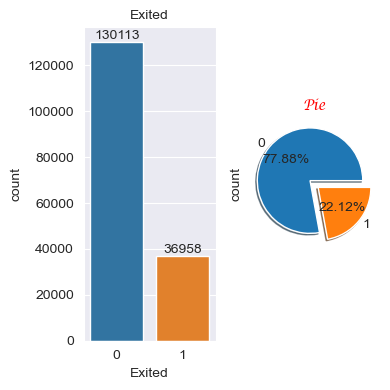

In [25]:
# Visualize the target balance
plot_binary_machine_failures(df_all, target)

In [26]:
df_all.Surname.value_counts()

Surname
Hsia            2461
T'ien           2284
Hs?             1614
Maclean         1582
Kao             1580
                ... 
Wickens            1
Speth              1
Cleveland          1
Suttor             1
Rapuluchukwu       1
Name: count, Length: 2827, dtype: int64

#### 모델의 성능을 향상을 위한 기능 추가

In [224]:
''' 
# dataset에 features 추가
def feature_engineering(df): 
    # Create interaction features 

    # Create time-based features

    news_cols = []
    return df, news_cols

# features 추가
train_eng, news_cols   = feature_engineering(df_all)
test_eng, news_cols    = feature_engineering(test)

# numeric_cols 업데이트
numeric_cols = numeric_cols + news_cols
'''

' \n# dataset에 features 추가\ndef feature_engineering(df): \n    # Create interaction features \n\n    # Create time-based features\n\n    news_cols = []\n    return df, news_cols\n\n# features 추가\ntrain_eng, news_cols   = feature_engineering(df_all)\ntest_eng, news_cols    = feature_engineering(test)\n\n# numeric_cols 업데이트\nnumeric_cols = numeric_cols + news_cols\n'

In [222]:
'''
# 데이터셋 비교
train_eng.drop(columns=["id", "CustomerId", "Surname"], inplace=True, axis=1)

test_id = test_eng["id"]   
test_eng.drop(columns= ["id", "CustomerId", "Surname"], inplace=True, axis=1)
test_eng.head(3)
'''

'\n# 데이터셋 비교\ntrain_eng.drop(columns=["id", "CustomerId", "Surname"], inplace=True, axis=1)\n\ntest_id = test_eng["id"]   \ntest_eng.drop(columns= ["id", "CustomerId", "Surname"], inplace=True, axis=1)\ntest_eng.head(3)\n'

In [223]:
'''
X  = train_eng.drop(columns=[target], axis=1)
y  = train_eng[target]
y.head(3)
'''

'\nX  = train_eng.drop(columns=[target], axis=1)\ny  = train_eng[target]\ny.head(3)\n'

In [115]:
X.head(3)

CreditScore Geography Gender   Age  Tenure  Balance  NumOfProducts  \
0          668    France   Male  33.0       3      0.0              2   
1          627    France   Male  33.0       1      0.0              2   
2          678    France   Male  40.0      10      0.0              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0        1.0             0.0        181449.97  
1        1.0             1.0         49503.50  
2        1.0             0.0        184866.69

## CatBoost Model building

### Preparing the data for CatBoost

In [161]:
# One-Hot Encoding을 수행할 특성 선택
ohe_columns = ['Geography', 'Gender']

# One-Hot Encoding 수행
train_ohe = pd.get_dummies(train[ohe_columns])

# 기존 데이터에서 One-Hot Encoding 대상 특성 제거
pre_ohe = train.drop(ohe_columns, axis=1)

# One-Hot Encoding된 데이터와 기존 데이터 결합
train_data = pd.concat([pre_ohe, train_ohe], axis=1)

# 열 순서 정렬 (Exited를 맨 뒤로 이동)
columns_order = [col for col in train_data.columns if col != 'Exited']
train_data = train_data[columns_order + ['Exited']]

train_data.head()


id  CustomerId         Surname  CreditScore   Age  Tenure    Balance  \
0   0    15674932  Okwudilichukwu          668  33.0       3       0.00   
1   1    15749177   Okwudiliolisa          627  33.0       1       0.00   
2   2    15694510           Hsueh          678  40.0      10       0.00   
3   3    15741417             Kao          581  34.0       2  148882.54   
4   4    15766172       Chiemenam          716  33.0       5       0.00   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0              2        1.0             0.0        181449.97   
1              2        1.0             1.0         49503.50   
2              2        1.0             0.0        184866.69   
3              1        1.0             1.0         84560.88   
4              2        1.0             1.0         15068.83   

   Geography_France  Geography_Germany  Geography_Spain  Gender_Female  \
0              True              False            False          False   
1              True              False            False          False   
2              True              False            False          False   
3              True              False            False          False   
4             False              False             True          False   

   Gender_Male  Exited  
0         True       0  
1         True       0  
2         True       0  
3         True       0  
4         True       0

In [162]:
y = train_data['Exited']
X = train_data.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132027, 13), (33007, 13), (132027,), (33007,))

In [164]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([104090,  27937], dtype=int64))

In [166]:
train_data.head()

id  CustomerId         Surname  CreditScore   Age  Tenure    Balance  \
0   0    15674932  Okwudilichukwu          668  33.0       3       0.00   
1   1    15749177   Okwudiliolisa          627  33.0       1       0.00   
2   2    15694510           Hsueh          678  40.0      10       0.00   
3   3    15741417             Kao          581  34.0       2  148882.54   
4   4    15766172       Chiemenam          716  33.0       5       0.00   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0              2        1.0             0.0        181449.97   
1              2        1.0             1.0         49503.50   
2              2        1.0             0.0        184866.69   
3              1        1.0             1.0         84560.88   
4              2        1.0             1.0         15068.83   

   Geography_France  Geography_Germany  Geography_Spain  Gender_Female  \
0              True              False            False          False   
1              True              False            False          False   
2              True              False            False          False   
3              True              False            False          False   
4             False              False             True          False   

   Gender_Male  Exited  
0         True       0  
1         True       0  
2         True       0  
3         True       0  
4         True       0

In [169]:
'''
label_encoder = LabelEncoder()

# 범주형 데이터가 있는 열에 대해 레이블 인코딩 수행
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        X_train[column] = label_encoder.fit_transform(X_train[column])
'''
# 오버샘플링
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train_over.shape, y_train_over.shape)

(132027, 13) (33007, 13) (132027,) (33007,)
(208180, 13) (208180,)


In [204]:
train_data.head()

id  CustomerId         Surname  CreditScore   Age  Tenure    Balance  \
0   0    15674932  Okwudilichukwu          668  33.0       3       0.00   
1   1    15749177   Okwudiliolisa          627  33.0       1       0.00   
2   2    15694510           Hsueh          678  40.0      10       0.00   
3   3    15741417             Kao          581  34.0       2  148882.54   
4   4    15766172       Chiemenam          716  33.0       5       0.00   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0              2        1.0             0.0        181449.97   
1              2        1.0             1.0         49503.50   
2              2        1.0             0.0        184866.69   
3              1        1.0             1.0         84560.88   
4              2        1.0             1.0         15068.83   

   Geography_France  Geography_Germany  Geography_Spain  Gender_Female  \
0              True              False            False          False   
1              True              False            False          False   
2              True              False            False          False   
3              True              False            False          False   
4             False              False             True          False   

   Gender_Male  Exited  
0         True       0  
1         True       0  
2         True       0  
3         True       0  
4         True       0

In [217]:
'''
cat_features_index = [X_train.columns.get_loc(col) for col in ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']]

train_pool = Pool(X_train.to_numpy(), y_train.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)
val_pool = Pool(X_val.to_numpy(), y_val.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)
test_pool = Pool(test.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)
X_pool = Pool(X.to_numpy(), y.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)
'''

"\ncat_features_index = [X_train.columns.get_loc(col) for col in ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']]\n\ntrain_pool = Pool(X_train.to_numpy(), y_train.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)\nval_pool = Pool(X_val.to_numpy(), y_val.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)\ntest_pool = Pool(test.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)\nX_pool = Pool(X.to_numpy(), y.to_numpy(), feature_names=features_names_list, cat_features=cat_features_index)\n"

In [216]:
'''
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
features_names_list = X_train.columns.tolist()

train_pool    = Pool(X_train.to_numpy(), y_train.to_numpy(), feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])
val_pool      = Pool(X_val.to_numpy(), y_val.to_numpy(),     feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])

test_pool     = Pool(test.to_numpy(),                        feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])

X_pool        = Pool(X.to_numpy(), y.to_numpy(),             feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])
'''

"\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\nfeatures_names_list = X_train.columns.tolist()\n\ntrain_pool    = Pool(X_train.to_numpy(), y_train.to_numpy(), feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])\nval_pool      = Pool(X_val.to_numpy(), y_val.to_numpy(),     feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])\n\ntest_pool     = Pool(test.to_numpy(),                        feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])\n\nX_pool        = Pool(X.to_numpy(), y.to_numpy(),             feature_names = features_names_list, cat_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'])\n"

In [201]:
import time

def print_clf(y_test, pred, pred_proba):

    start_time = time.time()

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)

    confusion = confusion_matrix(y_test, pred)

    print('[Confusion Matrix]')
    print(confusion)
    print('=' * 10)

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc, pre)) 
    print('Recall : {0:.4f}, F1 : {1:.4f}, AUC : {2:.4f}'.format(re, f1, auc))
    print('Fit time : ', time.time() - start_time)
    print()

    return acc, pre, re, f1, auc
     

In [194]:
def get_result(model, X_train, y_train, X_test, y_test):

  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  pred_proba = model.predict_proba(X_test)[:, 1]

  return print_clf(y_test, pred, pred_proba)
     

In [195]:
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):

  col_names = ['Accuracy', 'Precision', 'Recall', 'f1', 'Roc_auc']
  tmp = []

  for model in models:

    tmp.append(get_result(model, X_train, y_train, X_test, y_test))

  return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [196]:
def draw_roc_curve(models, model_names, X_test, y_test):

  plt.figure(figsize=(10,10))

  for idx, model in enumerate(models):

    pred = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.plot(fpr, tpr, label=model_names[idx])

  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
  plt.title('ROC')
  plt.legend()
  plt.grid()
  plt.show()

In [209]:
lr = LogisticRegression(random_state=42, solver='liblinear')

dt = DecisionTreeClassifier(random_state=42, max_depth=3)

rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, random_state=42, n_jobs=-1, boost_from_average=False)

cb = CatBoostClassifier(n_estimators=1000, num_leaves=64, random_state=42, thread_count=-1, verbose=100, cat_features=cat_features_index)

In [211]:
models = [lr, dt, rf, lgbm, cb]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'CatBoost']

results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

results

[Confusion Matrix]
[[25078   945]
 [ 6095   889]]
Accuracy : 0.7867, Precision : 0.4847
Recall : 0.1273, F1 : 0.2016, AUC : 0.7241
Fit time :  0.24452805519104004

[Confusion Matrix]
[[25312   711]
 [ 4183  2801]]
Accuracy : 0.8517, Precision : 0.7976
Recall : 0.4011, F1 : 0.5337, AUC : 0.8437
Fit time :  0.15614604949951172

[Confusion Matrix]
[[25736   287]
 [  639  6345]]
Accuracy : 0.9719, Precision : 0.9567
Recall : 0.9085, F1 : 0.9320, AUC : 0.9851
Fit time :  0.14644503593444824

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[Confusion Matrix]
[[25302   721]
 [ 2113  4871]]
Accuracy : 0.9141, Precision : 0.

Accuracy  Precision    Recall        f1   Roc_auc
LogisticRegression  0.786712   0.484733  0.127291  0.201633  0.724092
DecisionTree        0.851728   0.797551  0.401060  0.533727  0.843744
RandomForest        0.971945   0.956725  0.908505  0.931992  0.985125
LightGBM            0.914139   0.871066  0.697451  0.774650  0.955956
CatBoost            0.875663   0.780374  0.573883  0.661386  0.905685

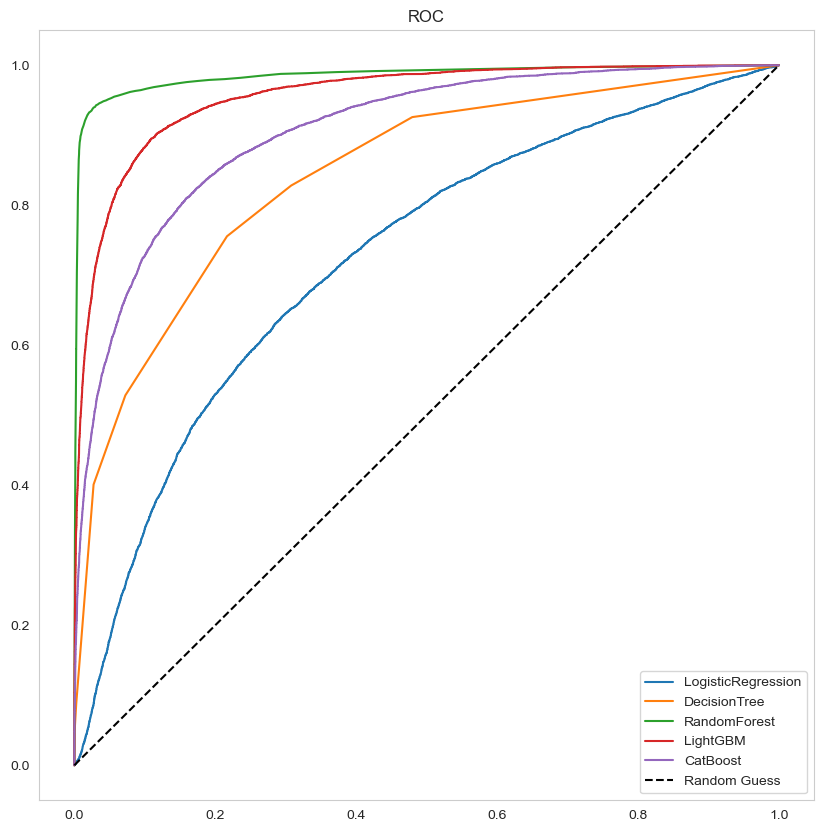

In [212]:
draw_roc_curve(models, model_names, X_test, y_test)

In [225]:
#ddm

In [213]:
models = [lr, dt, rf, lgbm, cb]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'CatBoost']

results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

results

[Confusion Matrix]
[[18849  7174]
 [ 2269  4715]]
Accuracy : 0.7139, Precision : 0.3966
Recall : 0.6751, F1 : 0.4997, AUC : 0.7551
Fit time :  0.20403695106506348

[Confusion Matrix]
[[20260  5763]
 [ 1652  5332]]
Accuracy : 0.7754, Precision : 0.4806
Recall : 0.7635, F1 : 0.5899, AUC : 0.8432
Fit time :  0.24090933799743652

[Confusion Matrix]
[[24267  1756]
 [ 3017  3967]]
Accuracy : 0.8554, Precision : 0.6932
Recall : 0.5680, F1 : 0.6244, AUC : 0.8715
Fit time :  0.14824986457824707

[LightGBM] [Info] Number of positive: 104090, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 208180, number of used features: 13
[Confusion Matrix]
[[24501  1522]
 [ 3072  3912]]
Accuracy : 0.8608, Precision : 

Accuracy  Precision    Recall        f1   Roc_auc
LogisticRegression  0.713909   0.396585  0.675115  0.499656  0.755123
DecisionTree        0.775351   0.480577  0.763459  0.589856  0.843179
RandomForest        0.855394   0.693168  0.568013  0.624380  0.871509
LightGBM            0.860817   0.719912  0.560137  0.630053  0.881574
CatBoost            0.865241   0.738705  0.561856  0.638256  0.888325

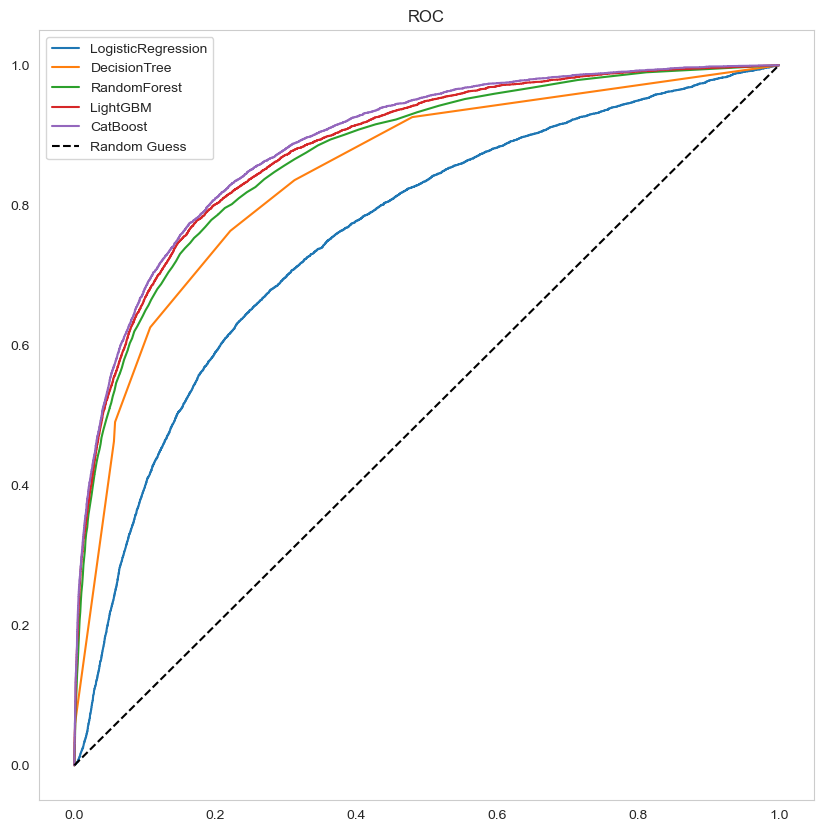

In [214]:
draw_roc_curve(models, model_names, X_test, y_test)

### Basic Approach

In [ ]:
model = models(random_seed=42, eval_metric='AUC')
model.fit(train, eval_set=val_pool, 
          verbose=50, plot=True)

In [33]:
model = CatBoostClassifier(random_seed=42, eval_metric='AUC')
model.fit(train_pool, eval_set=val_pool, 
          verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.106176
0:	test: 0.8621241	best: 0.8621241 (0)	total: 437ms	remaining: 7m 16s
50:	test: 0.8847094	best: 0.8847094 (50)	total: 11.4s	remaining: 3m 31s
100:	test: 0.8857286	best: 0.8857286 (100)	total: 20.7s	remaining: 3m 3s
150:	test: 0.8861118	best: 0.8861118 (150)	total: 31.6s	remaining: 2m 57s
200:	test: 0.8861303	best: 0.8861303 (200)	total: 42.1s	remaining: 2m 47s
250:	test: 0.8861019	best: 0.8861303 (200)	total: 51.5s	remaining: 2m 33s
300:	test: 0.8861585	best: 0.8861680 (292)	total: 1m 2s	remaining: 2m 25s
350:	test: 0.8861506	best: 0.8861927 (327)	total: 1m 16s	remaining: 2m 21s
400:	test: 0.8861755	best: 0.8861927 (327)	total: 1m 27s	remaining: 2m 10s
450:	test: 0.8861370	best: 0.8861927 (327)	total: 1m 37s	remaining: 1m 58s
500:	test: 0.8861057	best: 0.8861927 (327)	total: 1m 48s	remaining: 1m 48s
550:	test: 0.8860961	best: 0.8861927 (327)	total: 1m 58s	remaining: 1m 36s
600:	test: 0.8859704	best: 0.8861927 (327)	total: 2m 8s	remaining: 1m 25s
650:	test:

In [34]:
print("Train AUC :", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

Train AUC : 0.8861927150290366


In [35]:
predictions = model.predict_proba(test_eng)[:,1]
pd.DataFrame({'ID':test_id, 'Exited':predictions}
            ).to_csv('CatBoost_base_submission.csv', index=False)

### Improved approach

In [36]:
# specify some params
params ={'loss_function': 'Logloss',
         'eval_metric': 'AUC',
         'random_seed': 42,
         'learning_rate': 0.1, 
         'iterations': 1000, 
         'depth': 7, 
         'subsample': 0.7,
         'use_best_model': True,
         #'auto_class_weights': 'SqrtBalanced' # makes the AUC worse
        }

earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 100
})

model2 = CatBoostClassifier(**earlystop_params, )
model2.fit(train_pool, eval_set=val_pool, verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8621241	best: 0.8621241 (0)	total: 219ms	remaining: 3m 38s
50:	test: 0.8852616	best: 0.8852616 (50)	total: 10.5s	remaining: 3m 14s
100:	test: 0.8858854	best: 0.8858854 (100)	total: 19.8s	remaining: 2m 56s
150:	test: 0.8858765	best: 0.8859606 (130)	total: 29.6s	remaining: 2m 46s
200:	test: 0.8859522	best: 0.8860049 (174)	total: 39.5s	remaining: 2m 37s
250:	test: 0.8859696	best: 0.8860863 (232)	total: 49.6s	remaining: 2m 27s
300:	test: 0.8861219	best: 0.8861305 (297)	total: 59.7s	remaining: 2m 18s
350:	test: 0.8860958	best: 0.8861305 (297)	total: 1m 9s	remaining: 2m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8861304608
bestIteration = 297

Shrink model to first 298 iterations.


In [37]:
print("Train AUC :", roc_auc_score(y_val, model2.predict_proba(X_val)[:,1]))

Train AUC : 0.886130460830641


In [38]:
feature_importances = model2.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

NumOfProducts: 40.217164280711344
Age: 19.434642795527584
Balance: 9.942872257789313
IsActiveMember: 9.706069553830652
Geography: 5.610445800124806
Gender: 4.0134647087234265
CreditScore: 3.9924761793366716
EstimatedSalary: 3.769259472769525
Tenure: 2.2264901258819485
HasCrCard: 1.0871148253047302


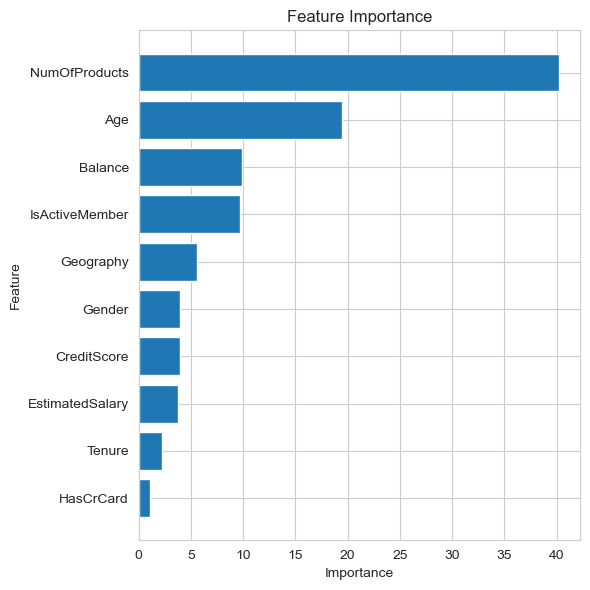

In [40]:
# 관계가 큰 항목순으로 데이터프레임 생성
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the dataframe by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)  # Sort in ascending order

# Create a vertical bar plot of feature importance
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [41]:
predictions2 = model2.predict_proba(test_pool)[:,1]
pd.DataFrame( {'id':test_id, 'Exited':predictions2}
            ).to_csv('CatBoost_submission_base2.csv', index=False)

----

----

---

## RandomForest 

In [40]:
train.dtypes
train["Exited"].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [43]:
#학습 데이터와 테스트 데이터 합해서 전처리하기
all_df = pd.concat([train, test], sort=False).reset_index(drop=True)
all_df["Exited"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
275052    NaN
275053    NaN
275054    NaN
275055    NaN
275056    NaN
Name: Exited, Length: 275057, dtype: float64

In [218]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# RandomForest 모델 정의
rf_model = RandomForestClassifier(random_state=42)

# 학습
rf_model.fit(X_train, y_train)

# 검증 데이터에 대한 예측 및 AUC 평가
rf_predictions = rf_model.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_predictions)
print("RandomForest AUC:", rf_auc)

# 테스트 데이터에 대한 예측 및 결과 저장
rf_test_predictions = rf_model.predict_proba(test_eng)[:, 1]
pd.DataFrame({'ID': test_id, 'Exited': rf_test_predictions}).to_csv('RandomForest_submission.csv', index=False)
'''


'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import roc_auc_score\n\n# RandomForest 모델 정의\nrf_model = RandomForestClassifier(random_state=42)\n\n# 학습\nrf_model.fit(X_train, y_train)\n\n# 검증 데이터에 대한 예측 및 AUC 평가\nrf_predictions = rf_model.predict_proba(X_val)[:, 1]\nrf_auc = roc_auc_score(y_val, rf_predictions)\nprint("RandomForest AUC:", rf_auc)\n\n# 테스트 데이터에 대한 예측 및 결과 저장\nrf_test_predictions = rf_model.predict_proba(test_eng)[:, 1]\npd.DataFrame({\'ID\': test_id, \'Exited\': rf_test_predictions}).to_csv(\'RandomForest_submission.csv\', index=False)\n'

## XGBoost

In [220]:
'''
import xgboost as xgb

# XGBoost 모델 정의
xgb_model = xgb.XGBClassifier(random_state=42)

# 학습
xgb_model.fit(X_train, y_train)

# 검증 데이터에 대한 예측 및 AUC 평가
xgb_predictions = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_predictions)
print("XGBoost AUC:", xgb_auc)

# 테스트 데이터에 대한 예측 및 결과 저장
xgb_test_predictions = xgb_model.predict_proba(test_eng)[:, 1]
pd.DataFrame({'ID': test_id, 'Exited': xgb_test_predictions}).to_csv('XGBoost_submission.csv', index=False)
'''


'\nimport xgboost as xgb\n\n# XGBoost 모델 정의\nxgb_model = xgb.XGBClassifier(random_state=42)\n\n# 학습\nxgb_model.fit(X_train, y_train)\n\n# 검증 데이터에 대한 예측 및 AUC 평가\nxgb_predictions = xgb_model.predict_proba(X_val)[:, 1]\nxgb_auc = roc_auc_score(y_val, xgb_predictions)\nprint("XGBoost AUC:", xgb_auc)\n\n# 테스트 데이터에 대한 예측 및 결과 저장\nxgb_test_predictions = xgb_model.predict_proba(test_eng)[:, 1]\npd.DataFrame({\'ID\': test_id, \'Exited\': xgb_test_predictions}).to_csv(\'XGBoost_submission.csv\', index=False)\n'

## LightGBM

In [221]:
'''
import lightgbm as lgb

# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier(random_state=42)

# 학습
lgb_model.fit(X_train, y_train)

# 검증 데이터에 대한 예측 및 AUC 평가
lgb_predictions = lgb_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_predictions)
print("LightGBM AUC:", lgb_auc)

# 테스트 데이터에 대한 예측 및 결과 저장
lgb_test_predictions = lgb_model.predict_proba(test_eng)[:, 1]
pd.DataFrame({'ID': test_id, 'Exited': lgb_test_predictions}).to_csv('LightGBM_submission.csv', index=False)
'''


'\nimport lightgbm as lgb\n\n# LightGBM 모델 정의\nlgb_model = lgb.LGBMClassifier(random_state=42)\n\n# 학습\nlgb_model.fit(X_train, y_train)\n\n# 검증 데이터에 대한 예측 및 AUC 평가\nlgb_predictions = lgb_model.predict_proba(X_val)[:, 1]\nlgb_auc = roc_auc_score(y_val, lgb_predictions)\nprint("LightGBM AUC:", lgb_auc)\n\n# 테스트 데이터에 대한 예측 및 결과 저장\nlgb_test_predictions = lgb_model.predict_proba(test_eng)[:, 1]\npd.DataFrame({\'ID\': test_id, \'Exited\': lgb_test_predictions}).to_csv(\'LightGBM_submission.csv\', index=False)\n'